In [1]:
import os
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from timeit import default_timer as timer
from IPython.display import clear_output

In [2]:

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []    
    for i in range(len(X) - time_steps):
        clear_output(wait=True)
        print('modeling to keras ',round((i/(len(X) - time_steps))*100,2), ('%'), end='')
        s = round(timer() - start)
        if(s>60):
            s /=60
            print(' ', s, ' seconds')
        v = X.iloc[i: (i+time_steps), 2:4].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [4]:
#carregando datasets
print('loading dataset...')
train = pd.read_csv('../datasets/com_concept_drift/sdn_train_unormalized.csv')
test = pd.read_csv('../datasets/com_concept_drift/sdn_test_unormalized.csv')

train = train[train.delay>=0]
test = test[test.delay>=0]

train = train[train.delay<=10000] 
test = test[test.delay<=10000] 



loading dataset...


In [5]:
start = timer()
print('creating window')
TIME_STEPS = 1
X_train,Y_train = create_dataset(train, train.delay, time_steps=TIME_STEPS)
X_test,Y_test = create_dataset(test, test.delay, time_steps=TIME_STEPS)

print('2D to 3D duration: ', round(timer() - start))

modeling to keras  100.0 %  7.566666666666666  seconds
2D to 3D duration:  454


# setting LSTM

In [6]:
print('Init config LSTM')
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
             activation="relu",
            units=40,
            input_shape=(X_train.shape[1],X_train.shape[2]
                        
                        )
        )
    ))
model.add(keras.layers.Dense(units=40, activation="relu"))
model.add(keras.layers.Dense(units=40, activation="relu"))
model.add(keras.layers.Dense(units=40, activation="relu"))
model.add(keras.layers.Dense(units=40, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

Init config LSTM


# compiling

In [7]:
loss ="mse"
optim = tf.keras.optimizers.Adam(
    learning_rate=0.0001)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optim, 
             metrics=metrics
             )

# training 

In [8]:
print('Init Train')
start = timer()
history = model.fit(
    X_train, Y_train, 
    epochs=100, 
    batch_size= 10,
    validation_split=0.1,
    shuffle=False,
#     callbacks=[tensorboard_callback]
)
print('trraining duration: ',round(timer() - start))

Init Train
Epoch 1/100
4995/4995 [==============================] - 26s 4ms/step - loss: 14580.5859 - accuracy: 0.6374 - val_loss: 18913.1777 - val_accuracy: 0.0000e+00
Epoch 2/100
4995/4995 [==============================] - 17s 3ms/step - loss: 14446.4111 - accuracy: 0.2241 - val_loss: 19005.0879 - val_accuracy: 0.0000e+00
Epoch 3/100
4995/4995 [==============================] - 16s 3ms/step - loss: 14146.6279 - accuracy: 0.2245 - val_loss: 18833.5020 - val_accuracy: 0.0000e+00
Epoch 4/100
4995/4995 [==============================] - 18s 4ms/step - loss: 13078.6973 - accuracy: 0.3302 - val_loss: 17050.0820 - val_accuracy: 0.0000e+00
Epoch 5/100
4995/4995 [==============================] - 16s 3ms/step - loss: 6955.7529 - accuracy: 0.4381 - val_loss: 15327.6270 - val_accuracy: 0.0000e+00
Epoch 6/100
4995/4995 [==============================] - 13s 3ms/step - loss: 2431.8115 - accuracy: 0.5255 - val_loss: 9868.3564 - val_accuracy: 0.0000e+00
Epoch 7/100
4995/4995 [=====================

4995/4995 [==============================] - 18s 4ms/step - loss: 2007.9158 - accuracy: 0.7617 - val_loss: 1283.6879 - val_accuracy: 0.9908
Epoch 55/100
4995/4995 [==============================] - 15s 3ms/step - loss: 2094.5762 - accuracy: 0.7486 - val_loss: 1336.2581 - val_accuracy: 0.9908
Epoch 56/100
4995/4995 [==============================] - 14s 3ms/step - loss: 2037.0944 - accuracy: 0.7728 - val_loss: 1326.1891 - val_accuracy: 0.9908
Epoch 57/100
4995/4995 [==============================] - 13s 3ms/step - loss: 2093.2341 - accuracy: 0.7504 - val_loss: 1275.1062 - val_accuracy: 0.9908
Epoch 58/100
4995/4995 [==============================] - 13s 3ms/step - loss: 1943.3400 - accuracy: 0.7628 - val_loss: 1303.8997 - val_accuracy: 0.9908
Epoch 59/100
4995/4995 [==============================] - 16s 3ms/step - loss: 1994.2983 - accuracy: 0.7452 - val_loss: 1386.6346 - val_accuracy: 0.9908
Epoch 60/100
4995/4995 [==============================] - 14s 3ms/step - loss: 2113.7686 - accu

# saving model

In [9]:
print('Saving Model')
model.save('models/lstm')

Saving Model
INFO:tensorflow:Assets written to: models/lstm\assets


# loss training

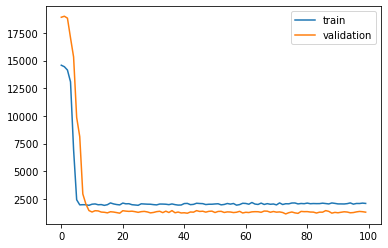

In [10]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend();

# accuracy

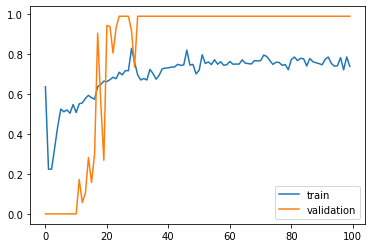

In [11]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(history.history['accuracy'], label='train')
ax1.plot(history.history['val_accuracy'], label='validation')
ax1.legend();

# predicting

In [12]:
y_pred = model.predict(X_test)

# unormalizing 

In [13]:
f_columns = ['temperature','label']
scaler1 = StandardScaler().fit(train[f_columns])
scaler2 = StandardScaler().fit(train[f_columns])

scaler1= scaler1.fit(train[f_columns].to_numpy())
scaler2 = scaler2.fit(train[['delay']])


#normalizando test
scaler3 = StandardScaler().fit(test[f_columns])
scaler4 = StandardScaler().fit(test[f_columns])

scaler3 = scaler3.fit(test[f_columns].to_numpy())
scaler4 = scaler4.fit(test[['delay']])


In [14]:
y_test_inv = scaler4.inverse_transform(Y_test.reshape(1,-1))
y_pred_inv = scaler4.inverse_transform(y_pred)

In [15]:
fig2 = plt.figure()
a2 = fig2.add_subplot(1,1,1)
a2.plot(y_test_inv, marker='.', label='true')
a2.legend();

ValueError: Image size of 394x1108477 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

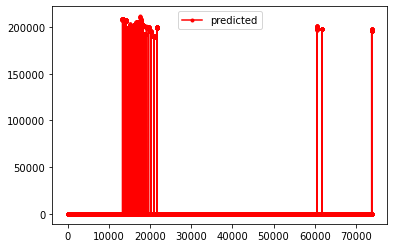

In [16]:
fig3 = plt.figure()
a3 = fig3.add_subplot(1,1,1)
a3.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a3.legend();


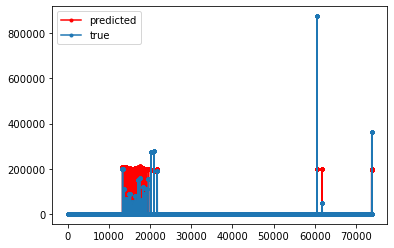

In [17]:
fig4 = plt.figure()
a4 = fig4.add_subplot(1,1,1)
a4.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a4.plot(y_test_inv.flatten(), marker='.', label='true')
a4.legend();

In [18]:
y_pred_inv.shape

(73897, 1)

In [19]:
l1 = []
l2 = []
for i in np.arange(y_pred_inv.shape[0]):
    clear_output(wait=True)
    print('progress ',round((i/y_pred_inv.shape[0])*100,2), ('%'))
    if(y_pred_inv[i,0]<=350000):
        l1.append(y_pred_inv[i,0])
    if(y_test_inv[0,i]<=350000):
        l2.append(y_test_inv[0,i])

y_pred_inv2 = np.array(l1)
y_test_inv2 = np.array(l2)

progress  100.0 %


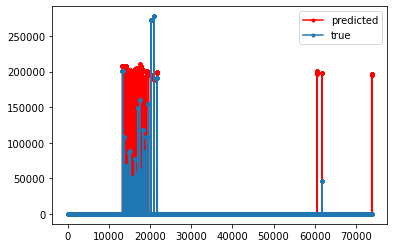

In [20]:



plt.plot(y_pred_inv2.flatten(),'r',marker='.', label='predicted')
plt.plot(y_test_inv2.flatten(), marker='.', label='true')
plt.legend();

In [21]:
y_pred_inv2

array([52.59361 , 52.670933, 52.82498 , ..., 48.09758 , 48.068893,
       48.09758 ], dtype=float32)

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error


In [23]:
rmse =  mean_squared_error(y_test_inv2, y_pred_inv2[0:73797], squared=False)
mae =  mean_absolute_error(y_test_inv2, y_pred_inv2[0:73797])
median_mae = median_absolute_error(y_test_inv2, y_pred_inv2[0:73797])
msle = mean_squared_log_error(y_test_inv2, y_pred_inv2[0:73797])

print(rmse)
print(mae)
print(median_mae)


15130.880225353534
1770.0267547094882
31.412939573154418


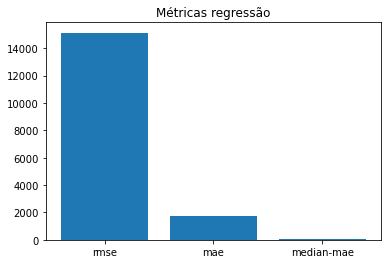

In [24]:
objects = ('rmse', 'mae', 'median-mae')
y_pos = np.arange(3)
performance = [rmse,mae,median_mae]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
#plt.ylabel('Usage')
plt.title('Métricas regressão')

plt.show()

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (4).

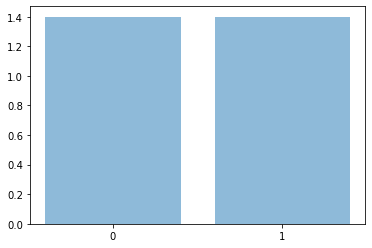

In [25]:
objects = ('msle')
y_pos = np.arange(2)
performance = [msle]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
#plt.ylabel('Usage')
plt.title('Métricas regressão')

plt.show()

In [ ]:
from sklearn.metrics import explained_variance_score

In [ ]:
explained_variance_score(y_test_inv2[0:size], y_pred_inv2[0:size])